# PIP-PRoS: Deteccção da bola

Neste notebook o algoritmo de detecção da bola por meio de um filtro HSV usado na implementação da versão robótica do jogo Pong é detalhado passo a passo.

Para mais informações, acesse [o site do projeto](https://sites.google.com/tecnico.ulisboa.pt/pip-pros/)!

## Bibliotecas utilizadas

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Imagem do campo utilizada como exemplo

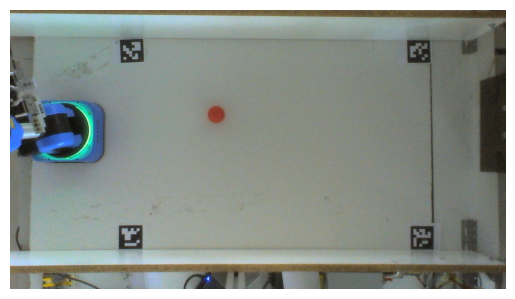

In [122]:
img = cv2.imread('../assets/images/field_example.png', 3)
h, w, _ = img.shape
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Ideia geral da solução

O objetivo deste algoritmo é obter a posição da bola na imagem do campo. 

De forma a simplificar esse processo, é assumido que a bola tem uma cor conhecida e diferente da cor do campo. Assim, para identificá-la basta filtrar na imagem apenas as regiões com a cor da bola, calcular os contornos dessas regiões e por fim definir como a bola o contorno que mais se assemelhar ao fomato esperado da bola (circularidade e valor de área condizente ao esperado).

## Filtro de cor para isolar a bola

A primeira etapa consiste em filtrar na imagem apenas as regiões que contém a cor da bola. Esse processo é realizado usando o conceito de espaço de cores HSV e a função ```cv2.inRange```, cuja documentação oficial descreve bem seu uso e pode ser acessada [por aqui](https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html). 

Diferentemente do espaço RGB, o mais comum para representar imagens, o espaço HSV codifica a cor em Matiz (_Hue_), Saturação (_Saturation_) e Brilho (_Value_), de forma que é possível facilmente encontrar um intervalo desses três valores que correspondem à cor da bola. Após transformar a cor em RGB da bola para o equivalente HSV é necessário estipular um pequeno intervalo em torno dos valores obtidos. Essa etapa envolve um pouco de experimentação, de forma que a bola seja identificada mesmo com variações de luz e posição na imagem.

Abaixo, com os limites superiores e inferiores é possível visualizar a ação da função cv2.inRange, que realiza o filtro da imagem conforme esses valores, precedida pela transformação do espaço RGB para o espaço HSV. Outra etapa importante a ser feita antes é um desfoque gaussiano na imagem, de forma a elimitar ruídos de alta frequência da imagem e facilitar a detecção da bola.

In [123]:
ball_hsv_lower = (0, 80, 0)
ball_hsv_upper = (20, 250, 200)

# First we blur the image with a GaussianBlur
blurred = cv2.GaussianBlur(img, (11, 11), 0)

# Construct a HSV mask for the ball color
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, ball_hsv_lower, ball_hsv_upper)

Por último, antes de calcular os contornos, é interessante diminuir o número de regiões pequenas ruidosas. Esse processo é normalmente feito por uma sequência de erosões e dilatações, como mostrado a seguir.

In [124]:
# Erode and dilate the result to remove small noises
mask_post_processed = cv2.erode(mask, None, iterations=4)
mask_post_processed = cv2.dilate(mask_post_processed, None, iterations=4)

O resultado dessa primeira etapa pode ser verificado na figura abaixo

Text(0.5, 1.0, 'Imagem após erosão e dilatação')

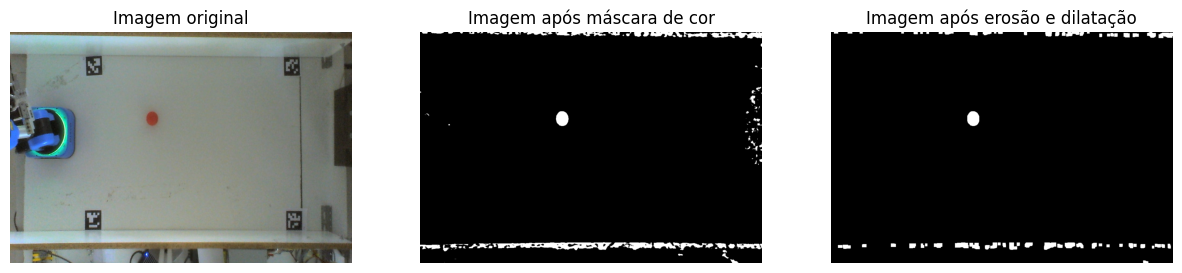

In [125]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for ax in axes:
    ax.axis("off")

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect="auto")
axes[0].set_title("Imagem original")

axes[1].imshow(mask, cmap='gray', aspect="auto")
axes[1].set_title("Imagem após máscara de cor")

axes[2].imshow(mask_post_processed, cmap='gray', aspect="auto")
axes[2].set_title("Imagem após erosão e dilatação")

## Identificação dos contornos

No contexto de visão computacional, os contornos são as curvas que conectam todos os pontos ao longo das fronteiras de objetos. São muito importantes nos processos de detecção e reconhecimento de objetos.

Para encontrar os contornos da imagem, basta usar o método ```cv2.findContours``` como segue.

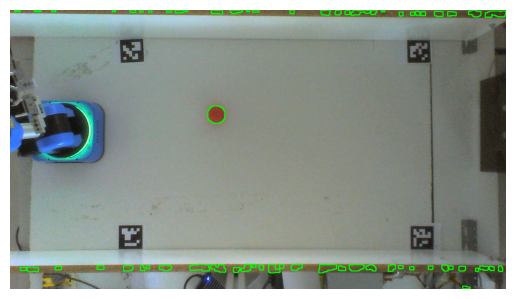

In [126]:
cnts, _ = cv2.findContours(mask_post_processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_with_contours = cv2.drawContours(img.copy(), cnts, -1, (0,255,0), 2)
plt.axis("off")
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))

Se nenhum contorno for identificado, assume-se que a bola não está presente no campo.

## Critérios numéricos de escolha do contorno da bola

É necessário agora escolher, dentre os contornos presentes na lista ```cnts```, qual corresponde à bola. Serão usados dois critérios: a "circularidade" do contorno - o quanto o contorno se assemelha a um círculo - e o valor numérico de àrea.

O primeiro a ser verificado será a área. Para isso é necessário definir os parâmetros de área mínima e máxima a serem identificadas (em pixels). Não é necessário que os valores sejam exatos, a função dessa verificação é apenas eliminar contornos espúrios.

In [127]:
minimum_ball_area = 300
maximum_ball_area = 3000

# Calculate the circularity of the identified countours
areas = np.array([cv2.contourArea(c) for c in cnts])
is_contour_valid = (areas > minimum_ball_area) & (areas < maximum_ball_area)
print("Número de contornos válidos:", np.sum(is_contour_valid))

Número de contornos válidos: 15


Em seguida, a circularidade de todos os contornos restantes é calculada, usando a definição usada pela [MathWorks](https://www.mathworks.com/help/images/identifying-round-objects.html;jsessionid=551254009a8e1c007e415ab76902).

O contorno com a maior circularidade é selecionado e para ele é aproximado um polígono, de forma a confirmar que o contorno tem formato circular.

Caso isso realmente se verifique, a posição (x, y) da bola pode ser calculada por meio da função ```cv2.minEnclosingCircle```.

In [128]:
perimeters = np.array([cv2.arcLength(c,True) for c in cnts])

circularities = 4 * np.pi * areas/(perimeters**2)
circularities = circularities*is_contour_valid
ball_cnt_idx = np.argmax(circularities)
# We get the one with the greatest circularity (4*pi*area/(perimeter^2))
c = cnts[ball_cnt_idx]
# And calculate the minimum enclosing circle
((x, y), radius) = cv2.minEnclosingCircle(c)
M = cv2.moments(c)
# Calculate the shape
approx = cv2.approxPolyDP(c, 0.01*cv2.arcLength(c,True),True)

# If the shape is really close to a circle and the area is greater than the minimum
# the contour is considered to be the ball
if (len(approx) > 5) & (len(approx) < 23):
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    img_with_ball = cv2.circle(img.copy(), (int(x), int(y)), int(radius), (0, 255, 0), 3)

Abaixo é possível encontrar a imagem onde a bola é destacada em verde.

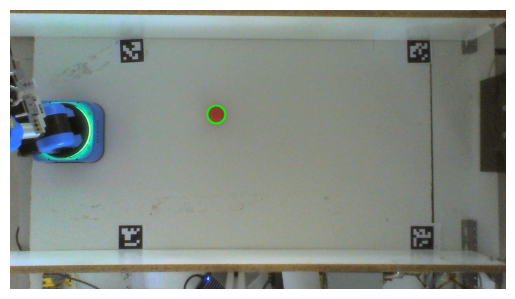

In [129]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img_with_ball, cv2.COLOR_BGR2RGB))